In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import kurtosis, skew
from scipy.stats import ttest_ind

In [ ]:
# Объединение датафреймов для последующей очистки данных от явных и неявных читеров
money_df = pd.read_csv('Money.csv')
cash_df = pd.read_csv('Cash.csv')
cheaters_df = pd.read_csv('Cheaters.csv')
merged_df = pd.merge(money_df, cash_df, on=['user_id', 'date'], how='outer')
merged_df = pd.merge(merged_df, cheaters_df, on='user_id', how='left')

print(merged_df)

                user_id        date  money  cash  cheaters
0         N4TS2T-P7YTVX  15.07.2021   1.99  1150         0
1         N4TS2T-P7YTVX  15.07.2021   1.99  1150         0
2         N4TS2T-P7YTVX  15.07.2021   1.99  1150         0
3         N4TS2T-P7YTVX  15.07.2021   1.99  1150         0
4         N4TS2T-P7YTVX  15.07.2021   1.99  1150         0
...                 ...         ...    ...   ...       ...
69119995  MQBLE4-6ESC3O  14.07.2021   0.00   250         0
69119996  MQBLE4-6ESC3O  14.07.2021   0.00   250         0
69119997  MQBLE4-6ESC3O  14.07.2021   0.00   250         0
69119998  MQBLE4-6ESC3O  14.07.2021   0.00   250         0
69119999  MQBLE4-6ESC3O  14.07.2021   0.00   250         0

[69120000 rows x 5 columns]


In [ ]:
# Осуществление агрегации данных (сокращение строк по дате, суммирование денег и внутриигровой валюты, и строк читеров)
merged_df_summed = merged_df.groupby('user_id', as_index=False).agg({
    'date': 'first',
    'money': 'sum',
    'cash': 'sum',
    'cheaters': 'first'
})

print(merged_df_summed)


               user_id        date  money   cash  cheaters
0        00036L-1T885I  10.07.2021  31.76  60800         0
1        0004MK-MRBUKF  15.07.2021  47.60  49200         0
2        0004MK-VW0O9L  14.07.2021  39.68  50400         0
3        0005S4-UEC6BE  13.07.2021  47.60  40000         0
4        0007I5-EWUD6O  11.07.2021  55.52  50800         0
...                ...         ...    ...    ...       ...
1079995  ZZZPEX-P2T8BH  10.07.2021  55.60  52800         0
1079996  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800         0
1079997  ZZZTR5-QSI6D3  11.07.2021   7.92  47200         0
1079998  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200         0
1079999  ZZZVH1-2OJT7I  17.07.2021  31.68  42000         0

[1080000 rows x 5 columns]


In [ ]:
# Подсчет количества читеров в объединенном датафрейме
count_cheaters = merged_df_summed['cheaters'].sum()

# Вывод количества читеров
print("Количество читеров:", count_cheaters)

Количество читеров: 353


In [ ]:
# Первая очистка данных от явных читеров
merged_df_summed_cleaned = merged_df_summed[merged_df_summed['cheaters'] != 1]

print(merged_df_summed_cleaned)


               user_id        date  money   cash  cheaters
0        00036L-1T885I  10.07.2021  31.76  60800         0
1        0004MK-MRBUKF  15.07.2021  47.60  49200         0
2        0004MK-VW0O9L  14.07.2021  39.68  50400         0
3        0005S4-UEC6BE  13.07.2021  47.60  40000         0
4        0007I5-EWUD6O  11.07.2021  55.52  50800         0
...                ...         ...    ...    ...       ...
1079995  ZZZPEX-P2T8BH  10.07.2021  55.60  52800         0
1079996  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800         0
1079997  ZZZTR5-QSI6D3  11.07.2021   7.92  47200         0
1079998  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200         0
1079999  ZZZVH1-2OJT7I  17.07.2021  31.68  42000         0

[1079647 rows x 5 columns]


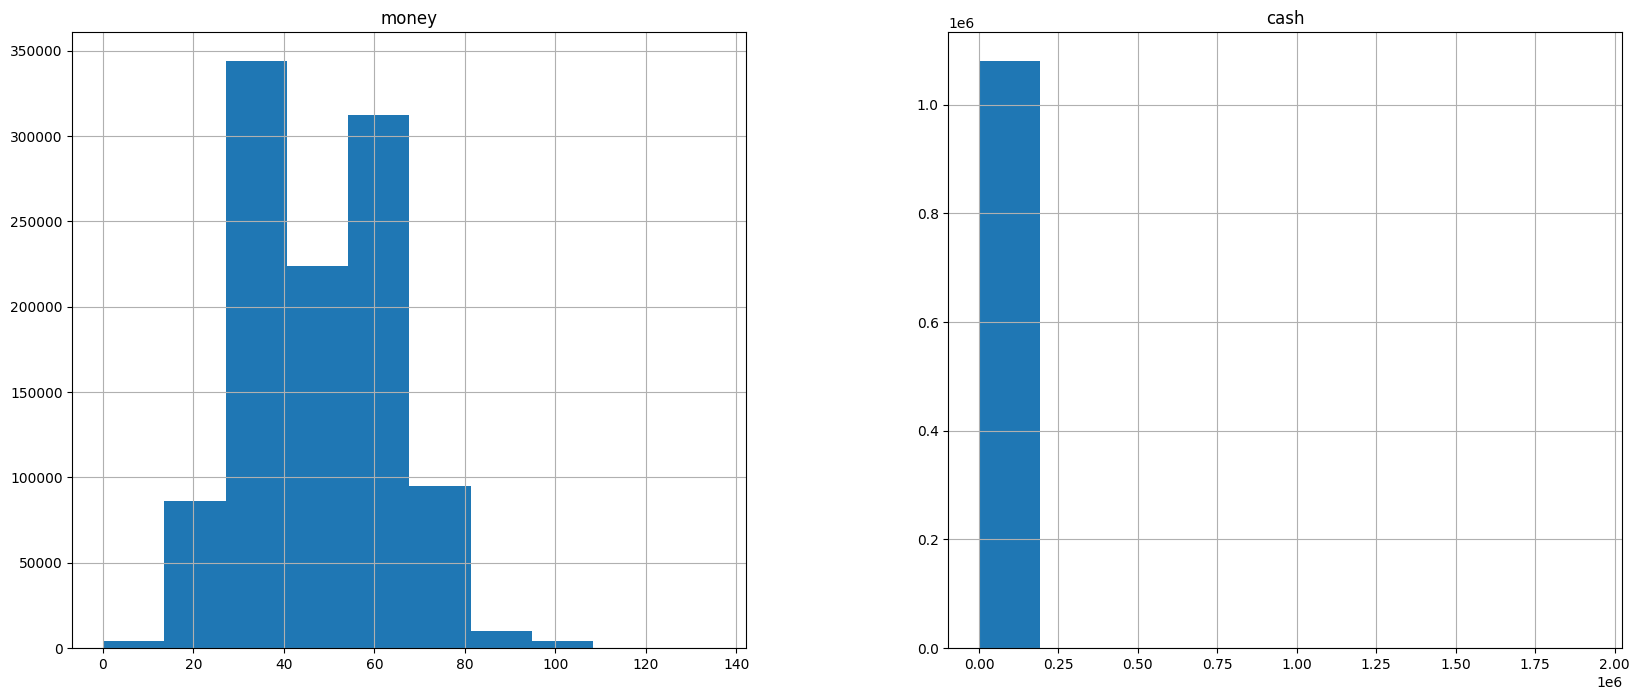

In [ ]:
# Начало анализа неявных читеров. Сперва смотрим на распределение значений столбцов по тратам денег и внутриигровой валюты
merged_df_summed_cleaned[['money', 'cash']].hist(figsize=(20, 8));

In [ ]:
# При ненормальном распределении значений применяем функцию для обнаружения выбросов методом межквартильного размаха IQR.

def outlier_iqr(data, col, threshold=3):

    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)

    anomalies = (data[col] > up_bound) | (data[col] < low_bound)
    return anomalies, up_bound, low_bound

# Вызов функции и получение результатов столбца money
anomalies, up_bound, low_bound = outlier_iqr(merged_df_summed_cleaned, 'money')

# Отображение результатов money
print("Границы интервала для выбросов:")
print("Верхняя граница:", up_bound)
print("Нижняя граница:", low_bound)
print("\nВыбросы:")
print(merged_df_summed_cleaned[anomalies])

# Вызов функции и получение результатов столбца cash
anomalies_cash, up_bound_cash, low_bound_cash = outlier_iqr(merged_df_summed_cleaned, 'cash')

# Отображение результатов cash
print("Границы интервала для выбросов в столбце 'cash':")
print("Верхняя граница:", up_bound_cash)
print("Нижняя граница:", low_bound_cash)
print("\nВыбросы в столбце 'cash':")
print(merged_df_summed_cleaned[anomalies_cash])


Границы интервала для выбросов:
Верхняя граница: 103.6
Нижняя граница: -8.399999999999999

Выбросы:
               user_id        date   money   cash  cheaters
634      00QXRC-DNSJ8D  13.07.2021  111.36  73200         0
4166     04YLLO-BY1P62  10.07.2021  111.44  88400         0
6345     07OEZ5-D4JQ19  16.07.2021  111.60  91600         0
12485    0EXXRN-BG0C73  15.07.2021  111.44  84800         0
12793    0FBAEW-O9WGNW  14.07.2021  119.52  90800         0
...                ...         ...     ...    ...       ...
1044442  YTIBGR-HCXFTM  10.07.2021  111.36  63600         0
1048303  YY2966-ITCEGU  14.07.2021  103.68  92000         0
1051584  Z238N9-2Y1YK8  14.07.2021  119.52  77600         0
1069112  ZMXCE4-XHTOT9  14.07.2021  111.52  72000         0
1077290  ZWQ77P-PN4WCH  10.07.2021  111.60  80800         0

[199 rows x 5 columns]
Границы интервала для выбросов в столбце 'cash':
Верхняя граница: 101200.0
Нижняя граница: -5200.0

Выбросы в столбце 'cash':
               user_id        

In [ ]:
# Нам интересны выбросы только в верхнем хвосте распределения данных, так как именно там найдутся неявные читеры,
# у которых мало данотов в игру при высокой трате внутриигровой валюты.
# В нижнем хвосте предположительно новички в игре


In [ ]:
# Установка значения 1 для строк, которые являются выбросами
merged_df_summed_cleaned.loc[anomalies_cash, 'cheaters'] = 1

# Вывод DataFrame для проверки
print(merged_df_summed_cleaned)


               user_id        date  money   cash  cheaters
0        00036L-1T885I  10.07.2021  31.76  60800         0
1        0004MK-MRBUKF  15.07.2021  47.60  49200         0
2        0004MK-VW0O9L  14.07.2021  39.68  50400         0
3        0005S4-UEC6BE  13.07.2021  47.60  40000         0
4        0007I5-EWUD6O  11.07.2021  55.52  50800         0
...                ...         ...    ...    ...       ...
1079995  ZZZPEX-P2T8BH  10.07.2021  55.60  52800         0
1079996  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800         0
1079997  ZZZTR5-QSI6D3  11.07.2021   7.92  47200         0
1079998  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200         0
1079999  ZZZVH1-2OJT7I  17.07.2021  31.68  42000         0

[1079647 rows x 5 columns]


In [ ]:
# Подсчет количества неявных читеров
count_cheaters2 = merged_df_summed_cleaned['cheaters'].sum()

# Вывод количества неявных читеров
print("Количество читеров:", count_cheaters2)


Количество читеров: 346


In [ ]:
# Вторая очистка данных от неявных читеров
merged_df_summed_cleaned_final = merged_df_summed_cleaned[merged_df_summed_cleaned['cheaters'] != 1]

print(merged_df_summed_cleaned_final)


               user_id        date  money   cash  cheaters
0        00036L-1T885I  10.07.2021  31.76  60800         0
1        0004MK-MRBUKF  15.07.2021  47.60  49200         0
2        0004MK-VW0O9L  14.07.2021  39.68  50400         0
3        0005S4-UEC6BE  13.07.2021  47.60  40000         0
4        0007I5-EWUD6O  11.07.2021  55.52  50800         0
...                ...         ...    ...    ...       ...
1079995  ZZZPEX-P2T8BH  10.07.2021  55.60  52800         0
1079996  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800         0
1079997  ZZZTR5-QSI6D3  11.07.2021   7.92  47200         0
1079998  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200         0
1079999  ZZZVH1-2OJT7I  17.07.2021  31.68  42000         0

[1079301 rows x 5 columns]


In [ ]:
# Удаление столбца 'cheaters'
merged_df_summed_without_cheaters = merged_df_summed_cleaned_final.drop('cheaters', axis=1)

print(merged_df_summed_without_cheaters)


               user_id        date  money   cash
0        00036L-1T885I  10.07.2021  31.76  60800
1        0004MK-MRBUKF  15.07.2021  47.60  49200
2        0004MK-VW0O9L  14.07.2021  39.68  50400
3        0005S4-UEC6BE  13.07.2021  47.60  40000
4        0007I5-EWUD6O  11.07.2021  55.52  50800
...                ...         ...    ...    ...
1079995  ZZZPEX-P2T8BH  10.07.2021  55.60  52800
1079996  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800
1079997  ZZZTR5-QSI6D3  11.07.2021   7.92  47200
1079998  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200
1079999  ZZZVH1-2OJT7I  17.07.2021  31.68  42000

[1079301 rows x 4 columns]


In [ ]:
# Сохранение в новом файле
merged_df_summed_without_cheaters.to_csv('merged_df_summed_without_cheaters.csv', index=False)


In [ ]:
users_df = pd.read_csv('merged_df_summed_without_cheaters.csv')
print(users_df)

               user_id        date  money   cash
0        00036L-1T885I  10.07.2021  31.76  60800
1        0004MK-MRBUKF  15.07.2021  47.60  49200
2        0004MK-VW0O9L  14.07.2021  39.68  50400
3        0005S4-UEC6BE  13.07.2021  47.60  40000
4        0007I5-EWUD6O  11.07.2021  55.52  50800
...                ...         ...    ...    ...
1079296  ZZZPEX-P2T8BH  10.07.2021  55.60  52800
1079297  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800
1079298  ZZZTR5-QSI6D3  11.07.2021   7.92  47200
1079299  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200
1079300  ZZZVH1-2OJT7I  17.07.2021  31.68  42000

[1079301 rows x 4 columns]


In [ ]:
# Источник данных был предварительно очищен от дубликатов
platforms_df = pd.read_csv('Platforms_cleaned.csv')
print(platforms_df)

               user_id platform
0        NHFL0F-Y90OSH     XBox
1        MVPNHS-PBHB8S     XBox
2        1UWMRN-8NVCLI       PC
3        EHO5II-03X9PU      PS4
4        7C5ZAE-D1NCY9     XBox
...                ...      ...
1079995  16WSYQ-3HAAMX     XBox
1079996  24TKVV-NU27F4     XBox
1079997  NQ6KMF-17NVXH     XBox
1079998  FJ3O9O-BHSV3M      PS4
1079999  O96AC0-DWWI69      PS4

[1080000 rows x 2 columns]


In [ ]:
# Объединение датафреймов пользователей с платформами
users_by_platforms = pd.merge(users_df, platforms_df, on='user_id')

print(users_by_platforms)

               user_id        date  money   cash platform
0        00036L-1T885I  10.07.2021  31.76  60800     XBox
1        0004MK-MRBUKF  15.07.2021  47.60  49200      PS4
2        0004MK-VW0O9L  14.07.2021  39.68  50400       PC
3        0005S4-UEC6BE  13.07.2021  47.60  40000       PC
4        0007I5-EWUD6O  11.07.2021  55.52  50800       PC
...                ...         ...    ...    ...      ...
1079296  ZZZPEX-P2T8BH  10.07.2021  55.60  52800       PC
1079297  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800     XBox
1079298  ZZZTR5-QSI6D3  11.07.2021   7.92  47200     XBox
1079299  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200      PS4
1079300  ZZZVH1-2OJT7I  17.07.2021  31.68  42000       PC

[1079301 rows x 5 columns]


In [ ]:
# Объединение датафрейма с АБ группами
# ИД АБ группы тоже был предварительно очищен от дубликатов
ABgroup_df = pd.read_csv('ABGroup_cleaned.csv')
test_users_by_platforms = pd.merge(users_by_platforms, ABgroup_df, on='user_id')
print(test_users_by_platforms)

               user_id        date  money   cash platform    group
0        00036L-1T885I  10.07.2021  31.76  60800     XBox  control
1        0004MK-MRBUKF  15.07.2021  47.60  49200      PS4  control
2        0004MK-VW0O9L  14.07.2021  39.68  50400       PC     test
3        0005S4-UEC6BE  13.07.2021  47.60  40000       PC     test
4        0007I5-EWUD6O  11.07.2021  55.52  50800       PC     test
...                ...         ...    ...    ...      ...      ...
1079296  ZZZPEX-P2T8BH  10.07.2021  55.60  52800       PC     test
1079297  ZZZTEN-0QGZ3X  12.07.2021  47.76  36800     XBox     test
1079298  ZZZTR5-QSI6D3  11.07.2021   7.92  47200     XBox     test
1079299  ZZZV9K-NM9B4Z  16.07.2021  31.76  31200      PS4  control
1079300  ZZZVH1-2OJT7I  17.07.2021  31.68  42000       PC  control

[1079301 rows x 6 columns]


Метрики для столбца 'money':
Базовые метрики для столбца money
count    1.079301e+06
mean     4.796605e+01
std      1.519667e+01
min      0.000000e+00
25%      3.960000e+01
50%      4.760000e+01
75%      5.560000e+01
max      1.354400e+02
Name: money, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
money
47.60    111436
39.68    104014
31.68     79063
55.60     77249
39.60     72008
Name: count, dtype: int64
------------------------------------
Эксцесс  0.021167928234538724
Ассиметрия  0.23549507915857587


<ipython-input-18-0f942e28948f>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


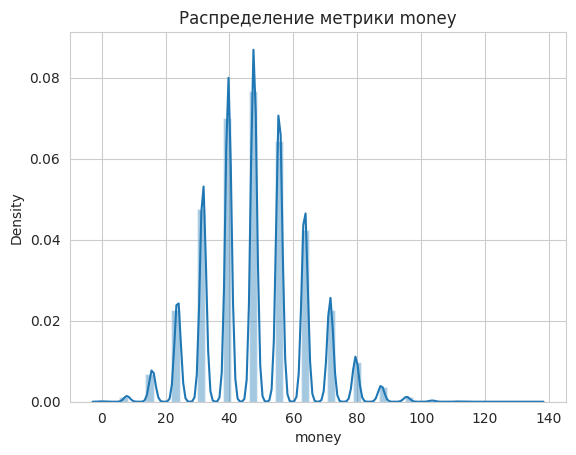


Метрики для столбца 'cash':
Базовые метрики для столбца cash
count    1.079301e+06
mean     4.812002e+04
std      1.116910e+04
min      4.000000e+02
25%      4.040000e+04
50%      4.800000e+04
75%      5.560000e+04
max      1.000000e+05
Name: cash, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
cash
48400    15629
48000    15600
46800    15510
48800    15501
47200    15499
Name: count, dtype: int64
------------------------------------
Эксцесс  0.014157960487613419
Ассиметрия  0.046038359421055566


<ipython-input-18-0f942e28948f>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


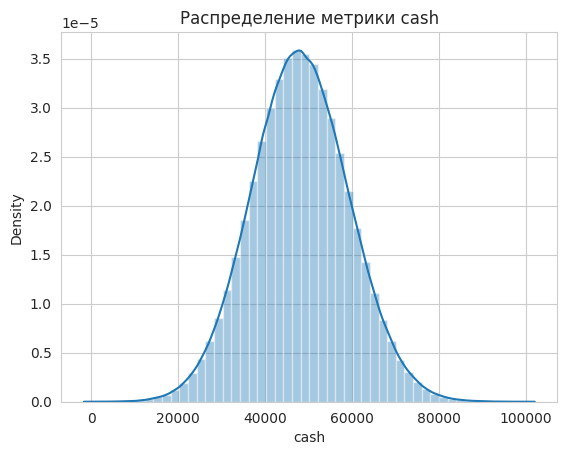

In [ ]:
# Создаем базовые метрики по столбцам трат и внутриигровой валюты и повторная проверка на нормальность распределения
def my_basic_research(df, column):
    print("Базовые метрики для столбца", column)
    print(df[column].describe())
    print("------------------------------------")

    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")

    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))

    sns.set_style('whitegrid')
    sns.distplot(df[column])
    plt.title("Распределение метрики " + column)
    plt.show()

print("Метрики для столбца 'money':")
my_basic_research(test_users_by_platforms, "money")

print("\nМетрики для столбца 'cash':")
my_basic_research(test_users_by_platforms, "cash")

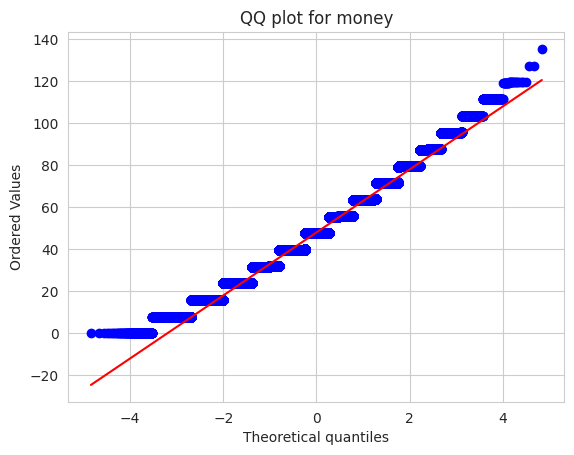

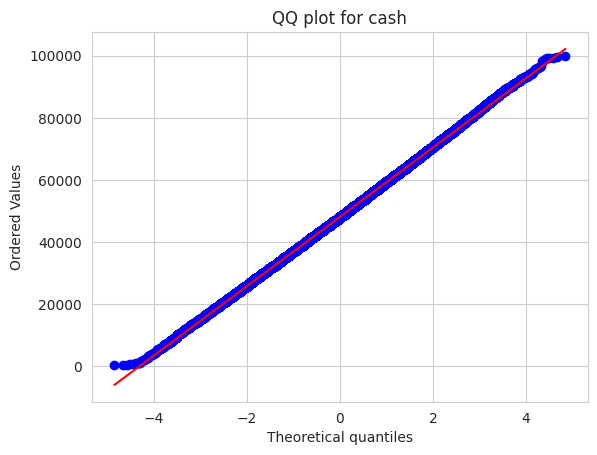

In [ ]:
# Построение QQ-графиков для столбцов донатов и внутриигровой валюты
def plot_qq(df, column):
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title("QQ plot for " + column)
    plt.show()

plot_qq(test_users_by_platforms, "money")
plot_qq(test_users_by_platforms, "cash")

In [ ]:
# Так как наши графики более приближенные к нормальному распределению, используем функцию для расчета
# доверительного интервала с использованием нормального распределения
def my_norm_confidence(df, column, alpha=0.95):
    interval = norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [ ]:
# Вычисление средних значений метрик для тестовой и контрольной групп
test_group_mean_money = test_users_by_platforms[test_users_by_platforms['group'] == 'test']['money'].mean()
control_group_mean_money = test_users_by_platforms[test_users_by_platforms['group'] == 'control']['money'].mean()

test_group_mean_cash = test_users_by_platforms[test_users_by_platforms['group'] == 'test']['cash'].mean()
control_group_mean_cash = test_users_by_platforms[test_users_by_platforms['group'] == 'control']['cash'].mean()

print(f"Среднее значение 'money' в тестовой группе: {test_group_mean_money}")
print(f"Среднее значение 'money' в контрольной группе: {control_group_mean_money}")

print(f"Среднее значение 'cash' в тестовой группе: {test_group_mean_cash}")
print(f"Среднее значение 'cash' в контрольной группе: {control_group_mean_cash}")

Среднее значение 'money' в тестовой группе: 49.297959095881765
Среднее значение 'money' в контрольной группе: 46.63582600450749
Среднее значение 'cash' в тестовой группе: 49836.57043258979
Среднее значение 'cash' в контрольной группе: 46405.64305701391


In [ ]:
# Группировка данных по платформам и группам
grouped_by_platform_and_group = test_users_by_platforms.groupby(['platform', 'group'])

# Вычисление средних значений метрик 'money' и 'cash' для каждой платформы и группы
average_metrics_by_platform_and_group = grouped_by_platform_and_group[['money', 'cash']].mean()

print(average_metrics_by_platform_and_group)


                      money          cash
platform group                           
PC       control  45.169611  44696.817484
         test     50.152072  51053.683982
PS4      control  45.901176  45455.489311
         test     48.678621  49043.628702
XBox     control  48.828167  49054.348175
         test     49.062127  49411.222977


In [ ]:
# Рассчитываем доверительные интервалы для каждой платформы внутри групп test и control
platforms = test_users_by_platforms['platform'].unique()

for platform in platforms:
    platform_test_data = test_users_by_platforms[(test_users_by_platforms['platform'] == platform) & (test_users_by_platforms['group'] == 'test')]
    platform_control_data = test_users_by_platforms[(test_users_by_platforms['platform'] == platform) & (test_users_by_platforms['group'] == 'control')]

    print(f"Доверительные интервалы для платформы {platform}:")

    # Рассчитываем доверительные интервалы для метрик 'money' и 'cash'
    print("Money:")
    money_lower, money_upper = my_norm_confidence(platform_test_data, 'money')
    print(f"Test Group: Нижняя граница: {money_lower}, Верхняя граница: {money_upper}")
    money_lower, money_upper = my_norm_confidence(platform_control_data, 'money')
    print(f"Control Group: Нижняя граница: {money_lower}, Верхняя граница: {money_upper}")

    print("Cash:")
    cash_lower, cash_upper = my_norm_confidence(platform_test_data, 'cash')
    print(f"Test Group: Нижняя граница: {cash_lower}, Верхняя граница: {cash_upper}")
    cash_lower, cash_upper = my_norm_confidence(platform_control_data, 'cash')
    print(f"Control Group: Нижняя граница: {cash_lower}, Верхняя граница: {cash_upper}")

    print("__________________________________________")


Доверительные интервалы для платформы XBox:
Money:
Test Group: Нижняя граница: 19.069501397937323, Верхняя граница: 79.05475344860056
Control Group: Нижняя граница: 18.968139365592435, Верхняя граница: 78.68819467890619
Cash:
Test Group: Нижняя граница: 27438.608383428673, Верхняя граница: 71383.8375702467
Control Group: Нижняя граница: 27107.166611343247, Верхняя граница: 71001.52973954756
__________________________________________
Доверительные интервалы для платформы PS4:
Money:
Test Group: Нижняя граница: 19.12402576329193, Верхняя граница: 78.23321681532515
Control Group: Нижняя граница: 16.626089149266807, Верхняя граница: 75.17626185516023
Cash:
Test Group: Нижняя граница: 27685.780522773675, Верхняя граница: 70401.47688188817
Control Group: Нижняя граница: 24532.56739124151, Верхняя граница: 66378.41122992376
__________________________________________
Доверительные интервалы для платформы PC:
Money:
Test Group: Нижняя граница: 19.8974695789473, Верхняя граница: 80.4066744770200

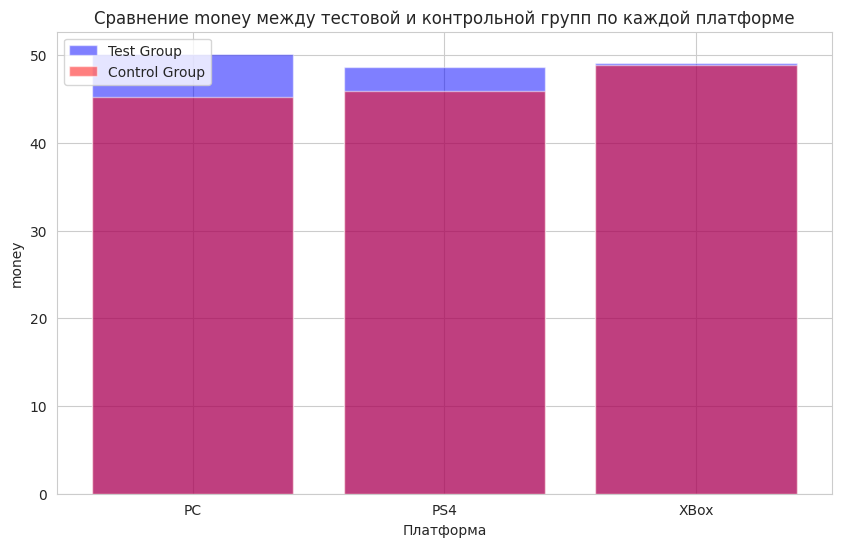

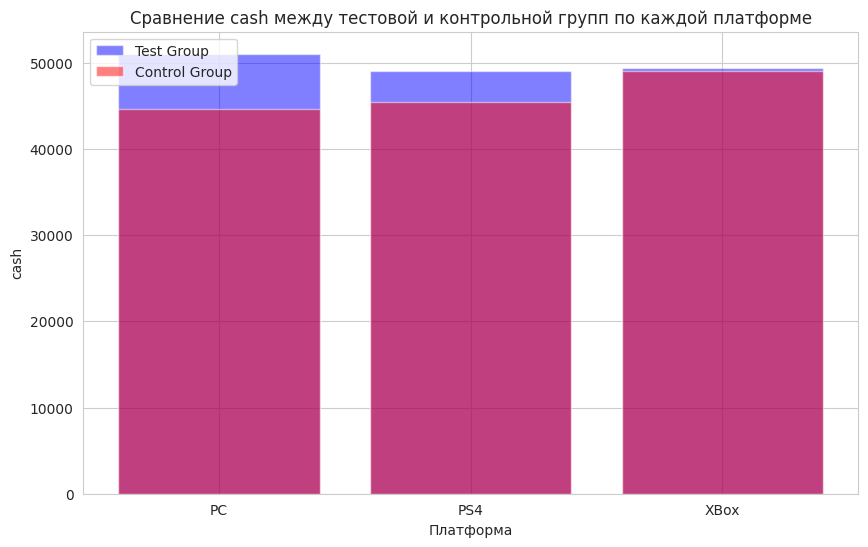

In [ ]:
# Визуплизация доверительных интервалов

def plot_comparison(data, metric):
    plt.figure(figsize=(10, 6))

    for group, color in [('test', 'b'), ('control', 'r')]:
        grouped_data = data[data['group'] == group].groupby('platform')[metric].mean()
        plt.bar(grouped_data.index, grouped_data, color=color, alpha=0.5, label=f'{group.capitalize()} Group')

    plt.xlabel('Платформа')
    plt.ylabel(metric)
    plt.title(f'Сравнение {metric} между тестовой и контрольной групп по каждой платформе')
    plt.legend()
    plt.show()

# Сравнение метрики 'money' между группами test и control для каждой платформы
plot_comparison(test_users_by_platforms, 'money')

# Сравнение метрики 'cash' между группами test и control для каждой платформы
plot_comparison(test_users_by_platforms, 'cash')


In [ ]:
# Грубо говоря, сравнение доверительных интервалов указывает на то, что они сильно пересекаются. Т.е. отсюда можно сделать вывод, что
# акции не повлияли сильно на прибыльность
# Тем не менее, графики указывают на то, что есть значимые влияния акции на платформах PC и PS4 у тестовой группы

In [ ]:
# НО в просторах интернета нашел функцию для проведения t-теста в качестве доп анализа
from scipy.stats import ttest_ind

def perform_t_test(data_group1, data_group2, metric):
    t_stat, p_value = ttest_ind(data_group1[metric], data_group2[metric])
    print(f"Результаты t-теста для метрики '{metric}':")
    print(f"t-статистика: {t_stat}")
    print(f"p-значение: {p_value}")
    if p_value < 0.05:
        print("Различия статистически значимы (p < 0.05)")
    else:
        print("Различия не являются статистически значимыми (p >= 0.05)")

# Проведение t-теста для метрики money
perform_t_test(test_users_by_platforms[test_users_by_platforms['group'] == 'test'],
               test_users_by_platforms[test_users_by_platforms['group'] == 'control'], 'money')

# Проведение t-теста для метрики cash
perform_t_test(test_users_by_platforms[test_users_by_platforms['group'] == 'test'],
               test_users_by_platforms[test_users_by_platforms['group'] == 'control'], 'cash')

# Полученные результаты показывают, что различия между тестовой и контрольной группами по метрикам money и cash
# являются статистически значимыми, так как p-значения значительно меньше 0.05. Это означает, что
# проведенная акция имеет статистически значимое влияние на показатели money и cash


Результаты t-теста для метрики 'money':
t-статистика: 91.3471052889679
p-значение: 0.0
Различия статистически значимы (p < 0.05)
Результаты t-теста для метрики 'cash':
t-статистика: 161.4798411869507
p-значение: 0.0
Различия статистически значимы (p < 0.05)


In [ ]:
# Рассчитываем ARPU (средняя прибыль на игрока)
ARPU = test_users_by_platforms.groupby(['group', 'platform'])['money'].sum() / test_users_by_platforms.groupby(['group', 'platform'])['user_id'].nunique()

# Рассчитываем ARPPU (средняя прибыль на платящего игрока)
paying_users = test_users_by_platforms[test_users_by_platforms['money'] > 0].groupby(['group', 'platform'])['user_id'].nunique()
ARPPU = test_users_by_platforms.groupby(['group', 'platform'])['money'].sum() / paying_users

# Выводим результаты
print("ARPU:")
print(ARPU)
print("\nARPPU:")
print(ARPPU)


ARPU:
group    platform
control  PC          45.169611
         PS4         45.901176
         XBox        48.828167
test     PC          50.152072
         PS4         48.678621
         XBox        49.062127
dtype: float64

ARPPU:
group    platform
control  PC          45.186455
         PS4         45.915731
         XBox        48.835474
test     PC          50.157651
         PS4         48.686491
         XBox        49.069485
dtype: float64


In [ ]:
# Отфильтруем данные по платящим и неплатящим игрокам
paying_players = test_users_by_platforms[test_users_by_platforms['money'] > 0]
non_paying_players = test_users_by_platforms[test_users_by_platforms['money'] == 0]

# Посчитаем количество игроков в каждой категории
total_players = len(test_users_by_platforms)
paying_players_count = len(paying_players)
non_paying_players_count = len(non_paying_players)

# Рассчитаем долю платящих и неплатящих игроков от общего числа игроков
paying_players_share = paying_players_count / total_players * 100
non_paying_players_share = non_paying_players_count / total_players * 100

# Выведем результаты
print("Доля платящих игроков:", round(paying_players_share, 2))
print("Доля неплатящих игроков:", round(non_paying_players_share, 2))


Доля платящих игроков: 99.98
Доля неплатящих игроков: 0.02


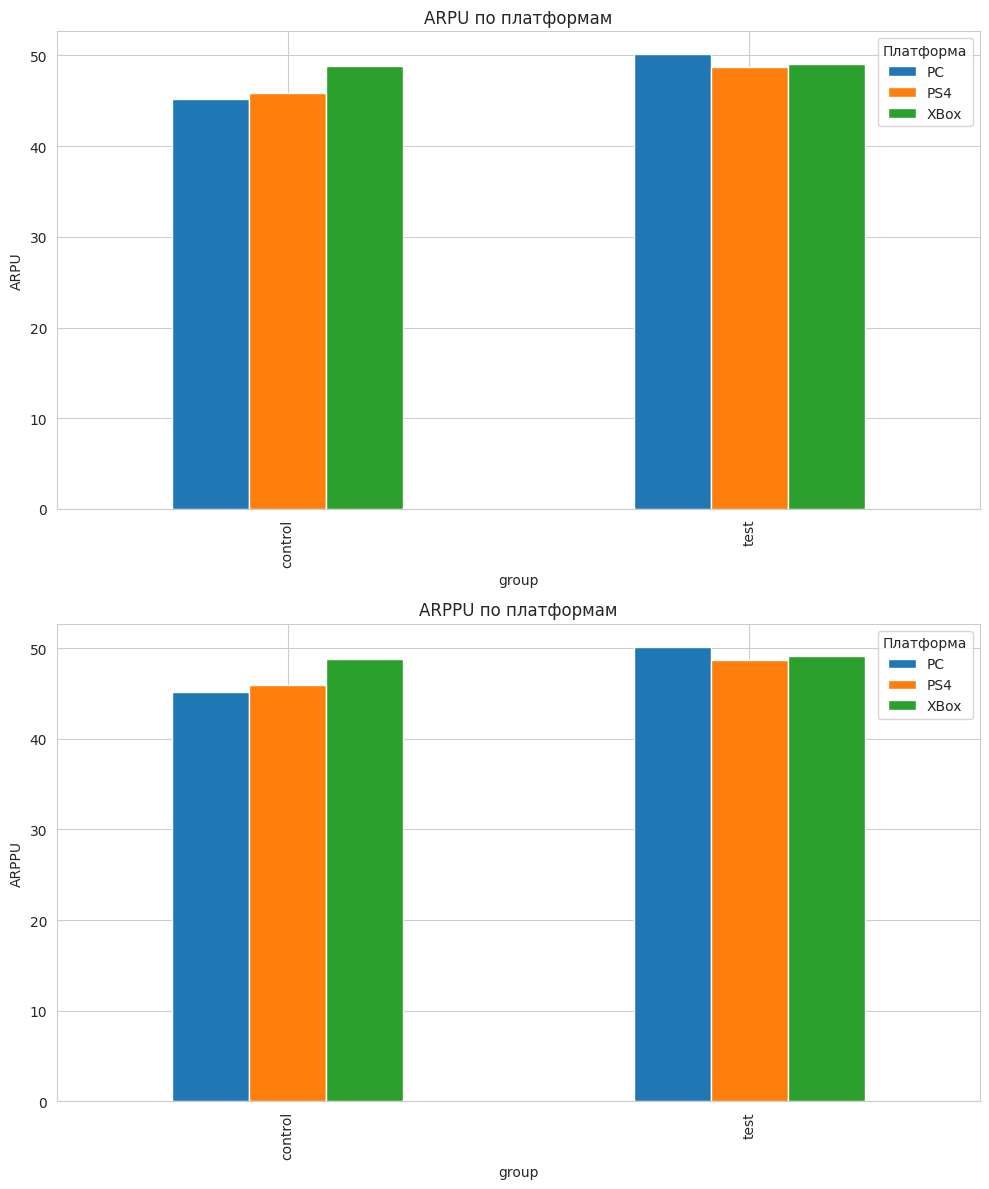

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

ARPU.unstack().plot(kind='bar', ax=axes[0])
axes[0].set_title('ARPU по платформам')
axes[0].set_ylabel('ARPU')
axes[0].legend(title='Платформа')

ARPPU.unstack().plot(kind='bar', ax=axes[1])
axes[1].set_title('ARPPU по платформам')
axes[1].set_ylabel('ARPPU')
axes[1].legend(title='Платформа')

plt.tight_layout()

plt.show()
